We want to explore what our huggingface dataset:

https://huggingface.co/datasets/Nicolas-BZRD/English_French_Songs_Lyrics_Translation_Original/viewer/default/train?row=23&views%5B%5D=train

entails and take choice regarding it

In [63]:
from Helpers import DataLoader

hf_song_ds = "Nicolas-BZRD/English_French_Songs_Lyrics_Translation_Original"
dl = DataLoader()

ds = dl.hf_loader(hf_song_ds)
#Use no as split usage
train_split = ds['train']
df = train_split.to_pandas()

In [64]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99289 entries, 0 to 99288
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       99289 non-null  object 
 1   album_name        99289 non-null  object 
 2   year              97953 non-null  float64
 3   title             99289 non-null  object 
 4   number            90670 non-null  float64
 5   original_version  80811 non-null  object 
 6   french_version    99289 non-null  object 
 7   language          80803 non-null  object 
dtypes: float64(2), object(6)
memory usage: 6.1+ MB
None


In [65]:
print(df["language"].describe())

count     80803
unique       37
top          en
freq      75786
Name: language, dtype: object


We take only the english to french songs

In [66]:
df = df[df["language"]== 'en'][["original_version", "french_version"]]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 75786 entries, 0 to 99288
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   original_version  75786 non-null  object
 1   french_version    75786 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB
None


In [67]:
print(df["original_version"][0])

chorus
Just let me hear some of that rock and roll music
Any old way you choose it
It's got a back beat, you can't lose it
Any old time you use it
It's gotta be rock and roll music
If you wanna dance with me
If you wanna dance with me
I've got no kick against modern jazz
Unless they try to play it too darn fast
And lose the beauty of the melody
Until they sound just like a symphony
That's why I go for that that rock and roll music
Any old way you choose it
It's got a back beat, you can't lose it
Any old time you use it
It's gotta be rock and roll music
If you wanna dance with me
If you wanna dance with me
I took my loved one over across the tracks
So she can hear my man awail a sax
I must admit they have a rocking band
Man, they were blowing like a hurricane
That's why I go for that that rock and roll music
Any old way you choose it
It's got a back beat, you can't lose it
Any old time you use it
It's gotta be rock and roll music
If you wanna dance with me
If you wanna dance with me
Way

In [68]:
print(df["french_version"][0])

Laisse moi juste écouter un peu de cette musique rock and roll
Choisis-la à l'ancienne
Il y a un backbeat, tu ne peux le perdre
Utilises-le à l'ancienneÇa sera de la musique rock
Si tu veux danser avec moi
Si tu veux danser avec moi
Je n'ai rien contre la musique jazz
Tant qu'ils n'essayent pas de la jouer trop rapidement
Et perdent la beauté de la mélodie
Jusqu'à ce que ça sonne comme une symphonie
C'est pour ça que je choisis cette musique rock and roll
Choisis-la à l'ancienne
Il y a un backbeat, tu ne peux le perdre
Utilises-le à l'ancienneÇa sera de la musique rock
Si tu veux danser avec moi
Si tu veux danser avec moi
J'ai emmené ma bien aimée sur la piste
Pour qu'elle puisse entendre le saxophoniste
Je dois admettre qu'ils ont un groupe de rock
Mec, ils défonçaient tout
C'est pour ça que je choisis cette musique rock and roll
Choisis-la à l'ancienne
Il y a un backbeat, tu ne peux le perdre
Utilises-le à l'ancienneÇa sera de la musique rock
Si tu veux danser avec moi
Si tu veux dan

In [69]:
mean_lenght_song_eng = df["original_version"].str.len().mean()
print(mean_lenght_song_eng)
mean_lenght_song_fr = df["french_version"].str.len().mean()
print(mean_lenght_song_fr)


1213.678397065421
1425.5381336922387


Now looking how to get our input/output matching tokens:

We look at a preprocessed naive implementation: tokenize the whole song on both sides  using Bert or XLNet(we will see later why it does not work)

In [ ]:
import pandas as pd

path_data = "Data/Bert_naive.parquet"
#tokenized df
df_naive = pd.read_parquet(path_data)
print(df_naive.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242609 entries, 0 to 1242608
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   input_token   1242609 non-null  object
 1   target_token  1242609 non-null  object
dtypes: object(2)
memory usage: 19.0+ MB
None


In [71]:
#check min, max sizes for the sequences of both language
print(df_naive["input_token"].str.len().max())
print(df_naive["input_token"].str.len().min())
print(df_naive["target_token"].str.len().max())
print(df_naive["target_token"].str.len().min())

429
1
812
1


As we see that tokenizers may be more efficient with english language (hence way less token for the same meaning of phrase) than for french, a problem arrise to separate correctly the same corresponding sequence from the different tokenization.

 A way to be safe would be to use the whole sequence in both language, but it will then create enormous data stored in memory which is clearly not feasible.For example, just the attention matrix for French would be of size (batch_size × num_heads × 8911 × 8911), not feasible.Furthermore it would involve some kind of gigantic padding for the smaller sequence which is clearly not efficient.

Now a way to deal with it is to separate the sequences by their meaning. As we have songs, which are structured, it may be possible. As we see above, each line is separated by a /n which means we do have a way of creating a line-to-line correspondance:

In [72]:
#e.g.:

original_split = df["original_version"][0].split(sep = '\n')
french_split = df["french_version"][0].split(sep = '\n')
print(original_split)
print(french_split)
print(len(original_split))
print(len(french_split))

['chorus', 'Just let me hear some of that rock and roll music', 'Any old way you choose it', "It's got a back beat, you can't lose it", 'Any old time you use it', "It's gotta be rock and roll music", 'If you wanna dance with me', 'If you wanna dance with me', "I've got no kick against modern jazz", 'Unless they try to play it too darn fast', 'And lose the beauty of the melody', 'Until they sound just like a symphony', "That's why I go for that that rock and roll music", 'Any old way you choose it', "It's got a back beat, you can't lose it", 'Any old time you use it', "It's gotta be rock and roll music", 'If you wanna dance with me', 'If you wanna dance with me', 'I took my loved one over across the tracks', 'So she can hear my man awail a sax', 'I must admit they have a rocking band', 'Man, they were blowing like a hurricane', "That's why I go for that that rock and roll music", 'Any old way you choose it', "It's got a back beat, you can't lose it", 'Any old time you use it', "It's got

It works well but as we see, some songs do have a difference in there line lengths. To ensure a proper working way, we take out every sentence with less than  16 characters. It ensures we take out all the basic sounds, the informative piece (like chorus above), etc.

In [73]:
original_split = [s for s in original_split if len(s) >= 16]
french_split = [s for s in french_split if len(s) >= 16]
print(original_split)
print(french_split)
print(len(original_split))
print(len(french_split))

['Just let me hear some of that rock and roll music', 'Any old way you choose it', "It's got a back beat, you can't lose it", 'Any old time you use it', "It's gotta be rock and roll music", 'If you wanna dance with me', 'If you wanna dance with me', "I've got no kick against modern jazz", 'Unless they try to play it too darn fast', 'And lose the beauty of the melody', 'Until they sound just like a symphony', "That's why I go for that that rock and roll music", 'Any old way you choose it', "It's got a back beat, you can't lose it", 'Any old time you use it', "It's gotta be rock and roll music", 'If you wanna dance with me', 'If you wanna dance with me', 'I took my loved one over across the tracks', 'So she can hear my man awail a sax', 'I must admit they have a rocking band', 'Man, they were blowing like a hurricane', "That's why I go for that that rock and roll music", 'Any old way you choose it', "It's got a back beat, you can't lose it", 'Any old time you use it', "It's gotta be rock

We still have some typos. Another way to clean it is maybe to separate the lines when a maj in the middle of a word (e.g. Utilises-le à l'ancienneCa sera de la musique rock").

In [74]:
import re
print(french_split[3])
test = re.split(r'([a-zàâäæáãåāèéêëęėēîïīįíìôōøõóòöœùûüūúÿç])([A-ZÀÂÄÆÁÃÅĀÈÉÊËĘĖĒÎÏĪĮÍÌÔŌØÕÓÒÖŒÙÛÜŪÚŸÇ])', french_split[3])
print(test)
test2  = re.sub(r'([a-zàâäæáãåāèéêëęėēîïīįíìôōøõóòöœùûüūúÿç])([A-ZÀÂÄÆÁÃÅĀÈÉÊËĘĖĒÎÏĪĮÍÌÔŌØÕÓÒÖŒÙÛÜŪÚŸÇ])', r'\1\n\2', french_split[3])

print(test2)

Utilises-le à l'ancienneÇa sera de la musique rock
["Utilises-le à l'ancienn", 'e', 'Ç', 'a sera de la musique rock']
Utilises-le à l'ancienne
Ça sera de la musique rock


Here we go:
1. check to add a correct separation of \n for each typos (both french and English) using a regex
2. Separate each sequences into subsequences using the \n separator
3. Take out the sequences smaller than a given size such that it takes out song patterns
4. If both song do not have the same length? take them out, they have too many typos
5. add it to a new df 

In [75]:
original_song = df["original_version"][1]
french_song = df["french_version"][1]

original_song = re.sub(r'([a-zàâäæáãåāèéêëęėēîïīįíìôōøõóòöœùûüūúÿç])([A-ZÀÂÄÆÁÃÅĀÈÉÊËĘĖĒÎÏĪĮÍÌÔŌØÕÓÒÖŒÙÛÜŪÚŸÇ])', r'\1\n\2', original_song)
french_song = re.sub(r'([a-zàâäæáãåāèéêëęėēîïīįíìôōøõóòöœùûüūúÿç])([A-ZÀÂÄÆÁÃÅĀÈÉÊËĘĖĒÎÏĪĮÍÌÔŌØÕÓÒÖŒÙÛÜŪÚŸÇ])', r'\1\n\2', french_song)

original_split = original_song.split(sep = '\n')
french_split = french_song.split(sep = '\n')

original_split = [s for s in original_split if len(s) >= 5]
french_split = [s for s in french_split if len(s) >= 5]
print(original_split)
print(french_split)
print(len(original_split))
print(len(french_split))

['Ever since I could remember', 'Everything inside of me', 'Just wanted to fit in', 'I was never one for pretenders', 'Everything I tried to be', "Just wouldn't settle in ", 'If I told you what I was', 'Would you turn your back on me ?And if I seem dangerous', 'Would you be scared ?', 'I get the feeling just because', "Everything I touch isn't dark enough", 'If this problem lies in me', "I'm only a man with a candle to guide me", "I'm taking a stand to escape what's inside me", 'A monster, a monster', "I'm turning to a monster", 'A monster, a monster', 'And it keeps getting stronger', 'Can I clear my conscience', "If I'm different from the rest Do I have to run and hide ? I never said that I want this", 'This burden came to me', "And it's made it's home inside", 'If I told you what I was', 'Would you turn your back on me ?And if I seem dangerous', 'Would you be scared ?', 'I get the feeling just because', "Everything I touch isn't dark enough", 'If this problem lies in me', "I'm only a

In [76]:
def split_string(str):
    sep_added = re.sub(r'([a-zàâäæáãåāèéêëęėēîïīįíìôōøõóòöœùûüūúÿç])([A-ZÀÂÄÆÁÃÅĀÈÉÊËĘĖĒÎÏĪĮÍÌÔŌØÕÓÒÖŒÙÛÜŪÚŸÇ])', r'\1\n\2', str)
    lines = sep_added.split(sep = '\n')
    lines = [s for s in lines if len(s) > 9]
    return lines

def split_both(list_origin, list_french, origin, french, count_origin):
    lines_origin = split_string(origin)
    lines_french = split_string(french)
    if len(lines_origin)==len(lines_french):
        for i in range(len(lines_origin)):
            list_origin.append(lines_origin[i])
            list_french.append(lines_french[i])
    else:
        count_origin += len(lines_origin)
    return list_origin, list_french, count_origin

In [77]:
list_sequences_origin = df["original_version"]
list_sequences_french = df["french_version"]


list_origin, list_french = [], []
count_taken_out = 0
for origin, french in zip(df["original_version"], df["french_version"]):
    list_origin, list_french, count_taken_out = split_both(list_origin, list_french, origin, french, count_taken_out)

print(len(list_origin))
print(len(list_french))
print(count_taken_out)


1242609
1242609
1468432


So we keep 1'242'609 lines from our initial text. We also throw 1'468'432 lines. Which means we throw around ~55% of our data

Here are the values:

    * len_min = 0: 1590518/2842174 (~55%)
    * len_min = 5: 1525856/2842174 (~54%)
    * len_min = 8: 1355048/2842174 (~48%)
    * len_min = 10: 1242609/1468432 (~45%)
    
At len_min >10 we create too many cleaning as we have a lot of word that are way smaller in english (4.7 char/word) than in french (7.85 char/word). To make a seemingly logical thinking, we will keep len_min = 10 as it means we keep lines with ~2 words in it in english at min. To make it work even more, a different logic could be applied for french words and english words but it becomes too convoluted

In [78]:
#create new df from the lists:
df_split = pd.DataFrame(list(zip(list_origin, list_french)), 
                      columns=["original_version", "french_version"])

print(df_split.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242609 entries, 0 to 1242608
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   original_version  1242609 non-null  object
 1   french_version    1242609 non-null  object
dtypes: object(2)
memory usage: 19.0+ MB
None


Okay now we have done the processing and tokenization in PreprocessSeq2Seq.py to have the line-by-line tokenization

In [90]:
df = pd.read_parquet('Data/Bert_close.parquet')

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242609 entries, 0 to 1242608
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   input_token   1242609 non-null  object
 1   target_token  1242609 non-null  object
dtypes: object(2)
memory usage: 19.0+ MB


In [81]:
#check min, max sizes for the sequences of both language
print(df["input_token"].str.len().max())
print(df["input_token"].str.len().min())
print(df["input_token"].str.len().mean())
print(df["target_token"].str.len().max())
print(df["target_token"].str.len().min())
print(df["target_token"].str.len().mean())

429
1
8.29169593975257
812
1
13.227404597906501


Big discrepencies let's have a vizualisation to understand more the line's length distribution:

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt


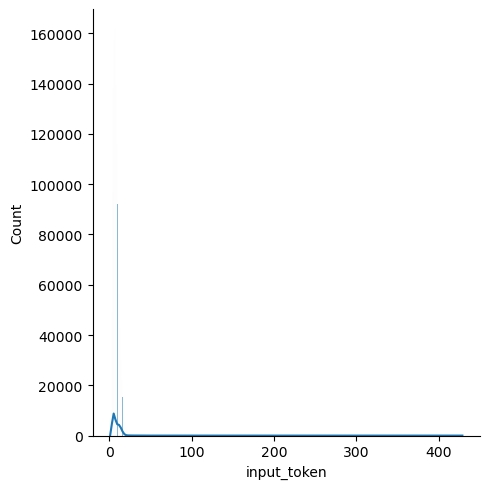

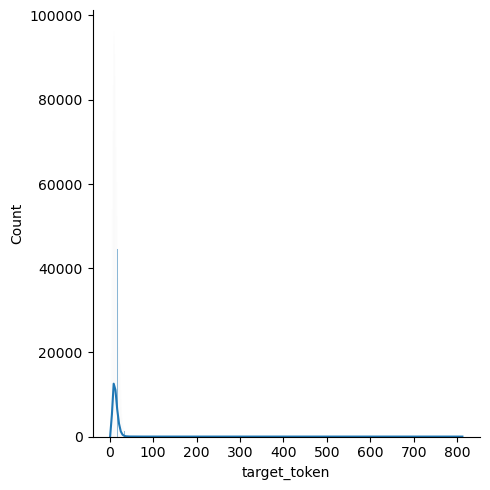

In [83]:
sns.displot(df["input_token"].str.len(), kde=True)
sns.displot(df["target_token"].str.len(), kde= True)
plt.show()

We see there is a clear presence of outliers which do represe

In [84]:
take_out_big = df[df["input_token"].str.len() <=32]
take_out_big2 = df[df["target_token"].str.len()<=32]
print(len(take_out_big))
print(len(take_out_big2))

1240342
1232472


By puttinh a hard margin of 32, which most likely will be our "sequence size" or block_size, we reduce our max sequence and  we take out only:

* english:
     - max: 429 --> 32
     - #seq: 1242609 --> """0342 **(-2267|~ -0,2%)**
* french: 
     - max: 829 --> 64
     - #seq: 1242609 --> ""32472 **(-10137|~ -0,8%)**

So it helps a lot our block size and therefore scalability. As we take out the rows where it is too big, we already take care of taking out pairs of input/target tokens. We just do it in a "and" logic and we get our new df:

In [87]:
df = df[(df["input_token"].str.len() <=32) & (df["target_token"].str.len()<=32)]
print(len(df))

1232040


We expected the english lines of more than 32 tokens to be a straight subset of the french ones, but suprisingly some english lines where bigger than the given token threshold while their french equivalent were within the range (exactly 432 english lines). It most likely means that either there was a problem within these lines or there was an error for some cases occuring in the splitting process of the songs. Either way, the "lost" lines are relatively small in total and can be seen as outliers in their behavior so correctly taken out.

Now we plot again the distribution:

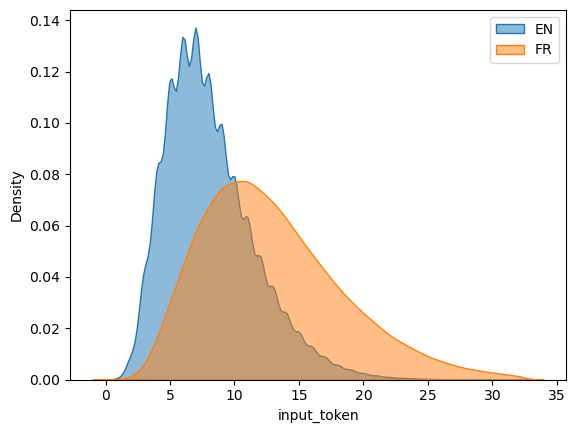

In [89]:
sns.kdeplot(df["input_token"].str.len(),label='EN', fill=True, alpha=0.5, bw_adjust=2)
sns.kdeplot(df["target_token"].str.len(), label='FR', fill=True, alpha=0.5, bw_adjust=2)
plt.legend()
plt.show()

Now we seemingly have well behaved and logical length distribution. As expected, the french lines are a tad longer. We add everything through our PreprocessSeq2Seq pipelone so we do not have to care about it afterwards. Note that both the Bert_native.parquet and Bert_close.parquet dataset can be found and must be exported before use in the exploration folder